## Import modules from standard libraries, datacube and files
Select 'Trust this notebook' to import these modules.

In [2]:
%matplotlib inline

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy as np
import os
import sys

#modules for datacube
import datacube
from datacube.storage import masking
from datacube.storage.storage import write_dataset_to_netcdf
from datacube.helpers import ga_pq_fuser, write_geotiff

# Import external functions from dea-notebooks
sys.path.append(os.path.expanduser('~/dea-notebooks/Scripts/'))
import DEAPlotting, DEADataHandling
from FileDialogs import *

#ignore datacube warnings (needs to be last import statement)
import warnings
warnings.filterwarnings('ignore', module='datacube')

# set datacube alias (just a string with what you're doing)
dc = datacube.Datacube(app='dc-polygonwofs')

In [3]:
#from the polygon drill notebook
from datacube.utils import geometry
import fiona
import rasterio.features

shape_file = '/g/data/r78/rjd547/Macquarie_Marsh/tile14-35.shp'

with fiona.open(shape_file) as shapes:
        crs = geometry.CRS(shapes.crs_wkt)
        first_geometry = next(iter(shapes))['geometry']
        geom = geometry.Geometry(first_geometry, crs=crs)

In [4]:
query = {'geopolygon': geom,
         'time': ('2016-07-01', '2017-07-01')
         }

data = dc.load(product='wofs_albers', group_by='solar_day', **query)

In [43]:
wetwofl = masking.make_mask(data, wet=True)
wofs = data.where(wetwofl)
del wetwofl

TypeError: where() got an unexpected keyword argument 'keep_attrs'

In [45]:
total_obs = wofs.sum(dim='time', keep_attrs=True)/128
clear_obs = data.count(dim='time', keep_attrs=True)

In [46]:
wofs_summary = (total_obs/clear_obs)*100

In [50]:
wofs_summary.attrs = total_obs.attrs
wofs_summary

<xarray.Dataset>
Dimensions:  (x: 4000, y: 4005)
Coordinates:
  * x        (x) float64 1.4e+06 1.4e+06 1.4e+06 1.4e+06 1.4e+06 1.4e+06 ...
  * y        (y) float64 -3.4e+06 -3.4e+06 -3.4e+06 -3.4e+06 -3.4e+06 ...
Data variables:
    water    (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Attributes:
    crs:      EPSG:3577

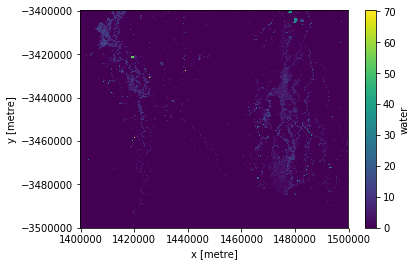

In [23]:
plt.clf()
wofs_summary.water.isel(x=range(0, len(wofs_summary.x),10), y=range(0, len(wofs_summary.y),10)).plot()
plt.show()

In [20]:
#save files to your home directory (add your outpath here if you want to change it)
savefilepath ='/g/data/r78/rjd547/Macquarie_Marsh/'

In [ ]:
#FC_quantiles['quantile'].attrs['units'] = 'quantile_unit'

In [51]:
wofs_summary

<xarray.Dataset>
Dimensions:  (x: 4000, y: 4005)
Coordinates:
  * x        (x) float64 1.4e+06 1.4e+06 1.4e+06 1.4e+06 1.4e+06 1.4e+06 ...
  * y        (y) float64 -3.4e+06 -3.4e+06 -3.4e+06 -3.4e+06 -3.4e+06 ...
Data variables:
    water    (y, x) float64 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ...
Attributes:
    crs:      EPSG:3577

In [54]:
write_geotiff(savefilepath+'Mac_Marsh_wofs_wy1617.tif',wofs_summary)